In [8]:
%matplotlib inline
import matplotlib
import matplotlib.units as units
import pandas as pd
import numpy as np
import math


print 'Read into data...'
print
data = pd.read_csv('data.csv')
print data.head(100)






Read into data...

             action_type combined_shot_type  game_event_id   game_id      lat  \
0              Jump Shot          Jump Shot             10  20000012  33.9723   
1              Jump Shot          Jump Shot             12  20000012  34.0443   
2              Jump Shot          Jump Shot             35  20000012  33.9093   
3              Jump Shot          Jump Shot             43  20000012  33.8693   
4      Driving Dunk Shot               Dunk            155  20000012  34.0443   
5              Jump Shot          Jump Shot            244  20000012  34.0553   
6             Layup Shot              Layup            251  20000012  34.0443   
7              Jump Shot          Jump Shot            254  20000012  34.0163   
8              Jump Shot          Jump Shot            265  20000012  33.9363   
9      Running Jump Shot          Jump Shot            294  20000012  33.9193   
10             Jump Shot          Jump Shot            309  20000012  33.8063   
11       

start exploring features...
some cool visualizations: 



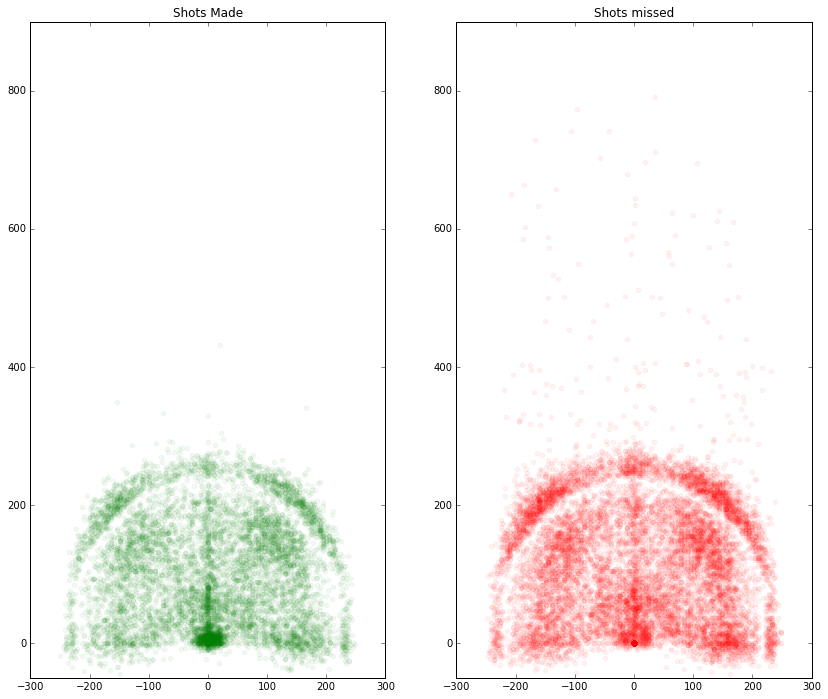

In [9]:
def feature_engineering(df):
  
    
    for i in ['game_event_id','game_id', 'team_id','shot_id', 'team_name']: 
        #drop unnecessary ids, drop team name, because it's always lakers
        df = df.drop(i, 1)
    
    df['game_date'] = pd.to_datetime(df['game_date']) #processing date string

    for i in ['year', 'month','day']:
        df[i] = getattr(df['game_date'].dt,i)

    df = df.drop('season',1)
    df = df.drop('game_date',1)
    
    #turn categorical data into dummy variables
    matchup = df['matchup'].values
    for i,j in enumerate(matchup):
        if '@' in j:
            matchup[i] = 'away'
        else:
            matchup[i] = 'home'
            
    for i in ['action_type','period','shot_type','shot_zone_area','shot_zone_basic','shot_zone_range','opponent', 'matchup']:
        dummy = pd.get_dummies(df[i])
        df = pd.concat([df, dummy],axis=1)
        df = df.drop(i,1)
    #value = np.add(np.multiply(df['loc_y'].values,df['loc_y'].values),np.multiply(df['loc_x'].values,df['loc_x'].values))
    #df['distance'] = np.sqrt(value)
    #did not drop combined_shot_type
    
    return df

print 'start exploring features...'
data = feature_engineering(data)


print 'some cool visualizations: '
print

import matplotlib.pyplot as plt

#from https://www.kaggle.com/arjoonn/kobe-bryant-shot-selection/preliminary-exploration

#misses and shots
plt.figure(figsize=(2*7, 7*(84.0/50.0)))
plt.subplot(121)
h = data.loc[data.shot_made_flag == 1]
plt.scatter(h.loc_x, h.loc_y, color='green', alpha = 0.05)
plt.title('Shots Made')
ax = plt.gca() #get axes instances
ax.set_ylim([-50, 900])

plt.subplot(122)
h = data.loc[data.shot_made_flag == 0]
plt.scatter(h.loc_x, h.loc_y, color='red', alpha=0.05)
plt.title('Shots missed')
ax = plt.gca()
ax.set_ylim([-50, 900])
#plt.show()
plt.savefig('shots_made_and_missed.png')




In [10]:
print data.info

<bound method DataFrame.info of       combined_shot_type      lat  loc_x  loc_y       lon  minutes_remaining  \
0              Jump Shot  33.9723    167     72 -118.1028                 10   
1              Jump Shot  34.0443   -157      0 -118.4268                 10   
2              Jump Shot  33.9093   -101    135 -118.3708                  7   
3              Jump Shot  33.8693    138    175 -118.1318                  6   
4                   Dunk  34.0443      0      0 -118.2698                  6   
5              Jump Shot  34.0553   -145    -11 -118.4148                  9   
6                  Layup  34.0443      0      0 -118.2698                  8   
7              Jump Shot  34.0163      1     28 -118.2688                  8   
8              Jump Shot  33.9363    -65    108 -118.3348                  6   
9              Jump Shot  33.9193    -33    125 -118.3028                  3   
10             Jump Shot  33.8063    -94    238 -118.3638                  1   
11      

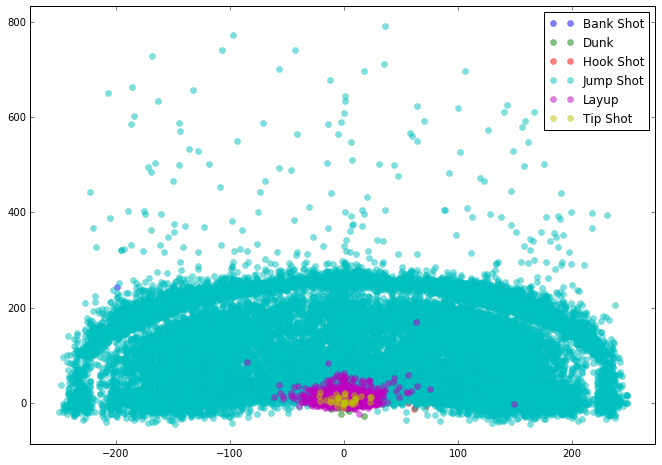

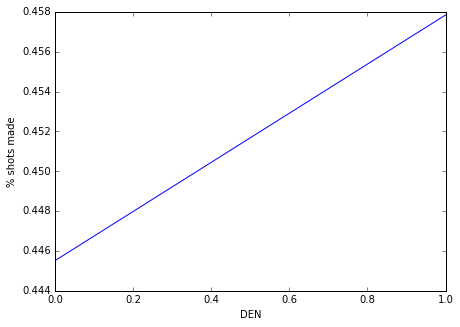

In [12]:
#shot types
groups = data.groupby('combined_shot_type')

fig, ax = plt.subplots(figsize=(2*7*0.8, 7*(84.0/60.0)*0.8))
ax.margins(0.05)
alpha = 0.2
alphas, n = [], float(len(data.combined_shot_type))
for u in [i[0] for i in groups]:
    d = len(data.loc[data.combined_shot_type == u, 'combined_shot_type'])
    alphas.append(np.log1p(d)) #transparency, more shots he makes, more opaque the shot is
for (name, group), alp in zip(groups, alphas):
    ax.plot(group.loc_x, group.loc_y,
            marker='.', linestyle='', ms=12,
            label=name, alpha=0.5)
ax.legend()
plt.show()
#plt.savefig('combined_shot_type_layout.png')

def get_acc(df, against):
    ct = pd.crosstab(df.shot_made_flag, df[against]).apply(lambda x:x/x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(against)
    plt.ylabel('% shots made')
    plt.savefig(against + '_vs_accuracy.png')


get_acc(data,"DEN")


In [13]:


##########implementation of machine learning algorithms################################
    

train = data[-pd.isnull(data.shot_made_flag)] #training observations are those without shot_made_flag as NaN
test = data[pd.isnull(data.shot_made_flag)]
test.drop('shot_made_flag', 1)

y = train['shot_made_flag'] #labels
X = train.drop('shot_made_flag', 1) #features
print train.head(10)
print train.columns.values

'''
#kfold cross validation
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.lda import LDA


kfold = KFold(n=len(X), n_folds = 10, random_state = 2288)

models = [('LR',LogisticRegression()), ('RF', RandomForestClassifier()), ('SVM',SVC(probability=True)),('lda', LDA()), ('GBC', GradientBoostingClassifier(n_estimators=100, random_state=2288, max_depth = 4, learning_rate = 0.1, max_features = 10))]
#Naive Bayes: -12, LR: -0.61, RF: -0.96

for name, model in models:
    print 'training ' + name + '...'
    results = cross_val_score(model, X, y, cv=kfold, scoring = 'log_loss')
    print name + ': ' + str(results.mean()) + ' +/- ' + str(results.std())
    
'''


   combined_shot_type      lat  loc_x  loc_y       lon  minutes_remaining  \
1           Jump Shot  34.0443   -157      0 -118.4268                 10   
2           Jump Shot  33.9093   -101    135 -118.3708                  7   
3           Jump Shot  33.8693    138    175 -118.1318                  6   
4                Dunk  34.0443      0      0 -118.2698                  6   
5           Jump Shot  34.0553   -145    -11 -118.4148                  9   
6               Layup  34.0443      0      0 -118.2698                  8   
8           Jump Shot  33.9363    -65    108 -118.3348                  6   
9           Jump Shot  33.9193    -33    125 -118.3028                  3   
10          Jump Shot  33.8063    -94    238 -118.3638                  1   
11          Jump Shot  33.9173    121    127 -118.1488                 11   

    playoffs  seconds_remaining  shot_distance  shot_made_flag  ...   POR  \
1          0                 22             15             0.0  ...   1.0  

"\n#kfold cross validation\nfrom sklearn.cross_validation import KFold, cross_val_score\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.lda import LDA\n\n\nkfold = KFold(n=len(X), n_folds = 10, random_state = 2288)\n\nmodels = [('LR',LogisticRegression()), ('RF', RandomForestClassifier()), ('SVM',SVC(probability=True)),('lda', LDA()), ('GBC', GradientBoostingClassifier(n_estimators=100, random_state=2288, max_depth = 4, learning_rate = 0.1, max_features = 10))]\n#Naive Bayes: -12, LR: -0.61, RF: -0.96\n\nfor name, model in models:\n    print 'training ' + name + '...'\n    results = cross_val_score(model, X, y, cv=kfold, scoring = 'log_loss')\n    print name + ': ' + str(results.mean()) + ' +/- ' + str(results.std())\n    \n"